<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/Hebbian_3_neuron_model_IIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simulation of an "USREY SYNAPSE"**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
total_time_ms = 100000  # Total simulation time in milliseconds
prob_A_fires = 0.25  # Probability of neuron A firing spontaneously
prob_B_fires = 0.20  # Probability of neuron B firing spontaneously
prob_C_fires = 0.22  # Spontaneous firing probability for neuron C

delay = 8  # Delay in ms for the effect of A or B on C
prob_C_fires_from_A = 0.18  # Probability of C firing given A fired
prob_C_fires_from_B = 0.14  # Probability of C firing given B fired
prob_C_fires_from_A_and_B = 0.78  # Probability of C firing given both A and B fired

# Initialize activity arrays
activity_A = np.random.rand(total_time_ms) < prob_A_fires
activity_B = np.random.rand(total_time_ms) < prob_B_fires
activity_C = np.zeros(total_time_ms, dtype=bool)

# Simulate the activity
for t in range(total_time_ms - delay):
    if activity_A[t] and activity_B[t]:
        # Both A and B fire simultaneously
        activity_C[t + delay] = activity_C[t + delay] or (np.random.rand() < prob_C_fires_from_A_and_B)
    elif activity_A[t]:
        # Only A fires
        activity_C[t + delay] = activity_C[t + delay] or (np.random.rand() < prob_C_fires_from_A)
    elif activity_B[t]:
        # Only B fires
        activity_C[t + delay] = activity_C[t + delay] or (np.random.rand() < prob_C_fires_from_B)

# Adding spontaneous activity for C
for t in range(total_time_ms):
    activity_C[t] = activity_C[t] or (np.random.rand() < prob_C_fires)

plot rasters

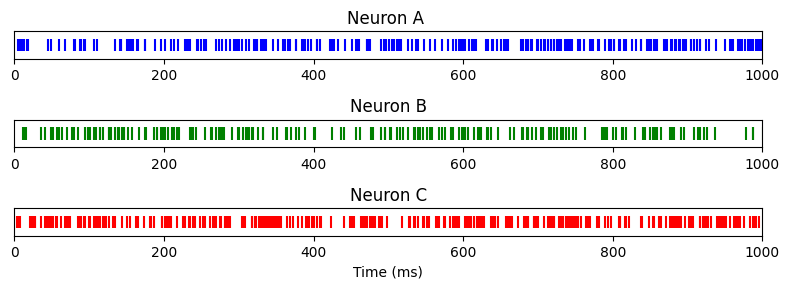

In [ ]:
# Plotting the activity of each neuron as raster plots

plt.figure(figsize=(8, 3))

# Neuron A activity
plt.subplot(3, 1, 1)
plt.eventplot(np.where(activity_A)[0], lineoffsets=1, colors='b')
plt.title("Neuron A ")
plt.ylabel("")
plt.yticks([])
plt.xlim(0, 1000)  # Displaying the first 1000 ms

# Neuron B activity
plt.subplot(3, 1, 2)
plt.eventplot(np.where(activity_B)[0], lineoffsets=1, colors='g')
plt.title("Neuron B")
plt.ylabel("")
plt.yticks([])
plt.xlim(0, 1000)  # Displaying the first 1000 ms

# Neuron C activity
plt.subplot(3, 1, 3)
plt.eventplot(np.where(activity_C)[0], lineoffsets=1, colors='r')
plt.title("Neuron C")
plt.xlabel("Time (ms)")
plt.yticks([])
plt.xlim(0, 1000)  # Displaying the first 1000 ms

plt.tight_layout()
plt.show()

indicate ternary moments

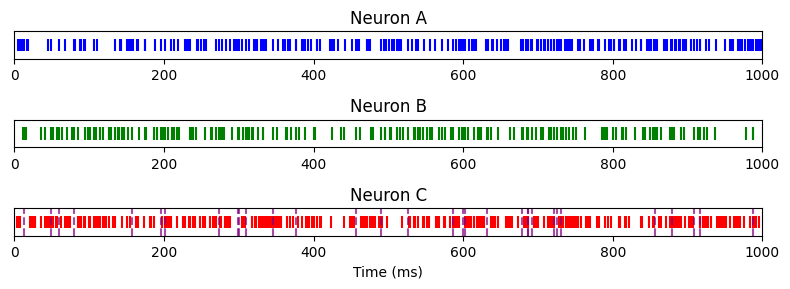

In [ ]:
# Adding an indication to the plot whenever A and B are both active at the same time and neuron C is active 8ms later

plt.figure(figsize=(8, 3))

# Neuron A activity
plt.subplot(3, 1, 1)
plt.eventplot(np.where(activity_A)[0], lineoffsets=1, colors='b')
plt.title("Neuron A")
plt.ylabel("")
plt.yticks([])
plt.xlim(0, 1000)  # Displaying the first 1000 ms

# Neuron B activity
plt.subplot(3, 1, 2)
plt.eventplot(np.where(activity_B)[0], lineoffsets=1, colors='g')
plt.title("Neuron B")
plt.ylabel("")
plt.yticks([])
plt.xlim(0, 1000)  # Displaying the first 1000 ms

# Neuron C activity
plt.subplot(3, 1, 3)
plt.eventplot(np.where(activity_C)[0], lineoffsets=1, colors='r')
plt.title("Neuron C")
plt.xlabel("Time (ms)")
plt.ylabel("")
plt.yticks([])
plt.xlim(0, 1000)  # Displaying the first 1000 ms

# Indicating moments when A and B are both active and C is active 8ms later
for t in range(1000 - delay):
    if activity_A[t] and activity_B[t] and activity_C[t + delay]:
        plt.axvline(x=t, color='purple', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

plot SBS time series

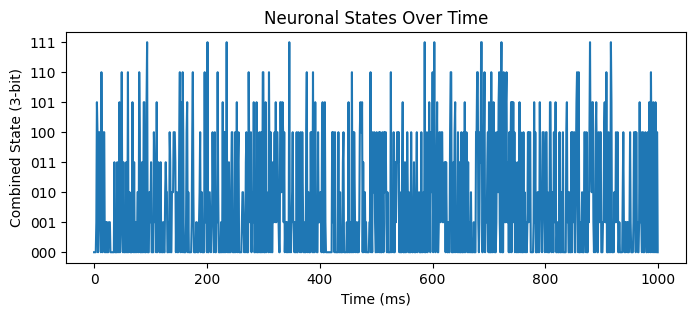

In [ ]:
# Convert to a single time series representing the 3-bit state
combined_activity = activity_A.astype(int) * 4 + activity_B.astype(int) * 2 + activity_C.astype(int)

# Plotting the time series
plt.figure(figsize=(8, 3))
plt.plot(combined_activity[:1000])  # Plotting only the first 1000 ms for better visibility
plt.title("Neuronal States Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Combined State (3-bit)")
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['000', '001', '010', '011', '100', '101', '110', '111'])
plt.show()

# TPM

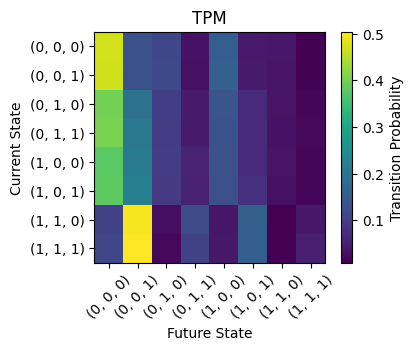

In [ ]:
from itertools import product

def create_transition_prob_matrix(time_series, delay, num_neurons):
    # Calculate the number of states
    num_states = 2 ** num_neurons

    # Create all possible states
    states = list(product([0, 1], repeat=num_neurons))

    # Initialize the transition probability matrix
    TPM = np.zeros((num_states, num_states))

    # Count transitions
    for t in range(len(time_series) - delay):
        current_state = time_series[t]
        next_state = time_series[t + delay]
        TPM[current_state, next_state] += 1

    # Normalize to get probabilities
    row_sums = TPM.sum(axis=1, keepdims=True)
    np.divide(TPM, row_sums, out=TPM, where=row_sums != 0)

    return TPM, states

# Generate the transition probability matrix for the current time series
TPM, states = create_transition_prob_matrix(combined_activity, delay, 3)

# Plotting the transition probability matrix
plt.figure(figsize=(4, 3))
plt.imshow(TPM, cmap='viridis', interpolation='none')
plt.colorbar(label='Transition Probability')
plt.xticks(range(len(states)), states, rotation=45)
plt.yticks(range(len(states)), states)
plt.xlabel('Future State')
plt.ylabel('Current State')
plt.title('TPM')
plt.show()

compute PHI time series

In [ ]:
!pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

# Check if a result file already exists to save time
if not os.path.exists('phi_results.pkl'):

  # Record the start time
  start_time = time.time()

  # Setting up the required parameters for pyPhi analysis
  labels = ('A', 'B', 'C')
  num_bits = len(labels)
  possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

  # Function to calculate phi values and states for a single TPM, tracking skipped trials
  def calculate_phi_for_tpm(tpm, possible_states, labels):
      converted_tpm = pyphi.convert.sbs2sbn(tpm)
      network = pyphi.Network(converted_tpm, node_labels=labels)
      node_indices = (0, 1, 2)

      phi_values = np.zeros(len(possible_states))
      phi_states = np.zeros((len(possible_states), 3), dtype=int)

      max_phi = -np.inf
      max_phi_state = None
      phi_mechanisms = []

      for i, state in enumerate(possible_states):
            candidate_system = pyphi.Subsystem(network, state, node_indices)
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            current_state_mechanisms = [distinction.mechanism for distinction in phi_structure.distinctions]
            phi_mechanisms.append(current_state_mechanisms)
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state

      return phi_values, phi_states, max_phi, max_phi_state, phi_mechanisms

  # Calculate phi values
  phi_results = calculate_phi_for_tpm(TPM, possible_states, labels)
  phi_values = phi_results[0]
  phi_states = phi_results[1]
  max_phi = phi_results[2]
  max_phi_state = phi_results[3]
  phi_mechanisms = phi_results[4]

  # Saving the results and the list of skipped trials
  with open('phi_results.pkl', 'wb') as file:
    pickle.dump(phi_results, file)

  # Record the end time and calculate duration
  end_time = time.time()
  elapsed_time = end_time - start_time
  # Convert elapsed time into hours, minutes, and seconds
  hours = int(elapsed_time // 3600)
  minutes = int((elapsed_time % 3600) // 60)
  seconds = elapsed_time % 60

  elapsed_time_formatted = f"{hours} hours, {minutes} minutes, {seconds:.2f} seconds"

  print(f"Elapsed time for PHI computation: {elapsed_time_formatted}")

else:
    print("File 'phi_results.pkl' already exists. Skipping computation.")

  Cloning https://github.com/wmayner/pyphi.git (to revision feature/iit-4.0) to /tmp/pip-req-build-fiofrs3h
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-req-build-fiofrs3h
  Resolved https://github.com/wmayner/pyphi.git to commit 83e887db466ed0c617cfb637f94a13d2aae8eea2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Elapsed time for PHI computation: 0 hours, 0 minutes, 18.38 seconds


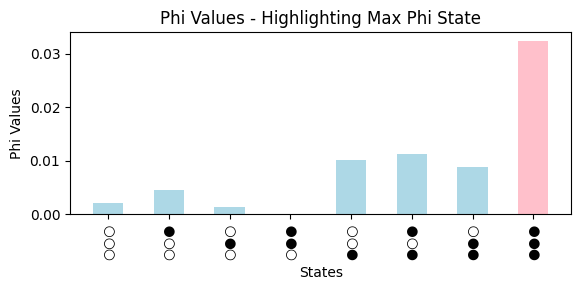

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming phi_results is already defined with the phi calculations

phi_values = phi_results[0]
phi_states = phi_results[1]
max_phi = phi_results[2]
max_phi_state = phi_results[3]
phi_mechanisms = phi_results[4]

# Convert states to symbolic representations for labeling
state_labels = [''.join('●' if bit == 1 else '○' for bit in state) for state in phi_states]

# Convert max_phi_state to the same symbolic representation
max_phi_state_label = ''.join('●' if bit == 1 else '○' for bit in max_phi_state)

# Define pastel colors
pastel_color = '#ADD8E6'  # Light blue
highlight_color = '#FFC0CB'  # Pastel red for highlighting max phi

# Creating the plot
fig, ax = plt.subplots(figsize=(6, 3))

# Plot Phi values
for state_label, phi_value in zip(state_labels, phi_values):
    color = highlight_color if state_label == max_phi_state_label else pastel_color
    ax.bar(state_label, phi_value, width=0.5, color=color)

# Setting titles and labels
ax.set_title('Phi Values - Highlighting Max Phi State')
ax.set_xlabel('States')
ax.set_ylabel('Phi Values')
ax.set_xticks(np.arange(len(state_labels)))
ax.set_xticklabels(state_labels, rotation=90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

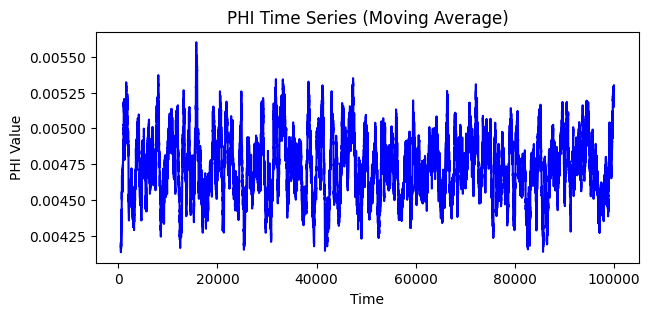

In [ ]:
# Extracting the necessary data from phi_results
phi_values = phi_results[0]
phi_states = phi_results[1]

# Mapping each state to its corresponding phi value
state_to_phi = {tuple(state): phi for state, phi in zip(phi_states, phi_values)}

# Convert each state in combined_activity to a tuple of 0s and 1s
def int_to_tuple(state, num_bits):
    return tuple((state >> i) & 1 for i in range(num_bits - 1, -1, -1))

# Reassigning the phi values to the respective states in the original time series sequence
phi_time_series = np.array([state_to_phi[int_to_tuple(state, num_bits)] for state in combined_activity])

# Compute a moving average of the phi time series
window_size = 512  # Define the window size for the moving average
moving_avg = np.convolve(phi_time_series, np.ones(window_size) / window_size, mode='valid')

# Plotting the time series of PHI values and the moving average
plt.figure(figsize=(7, 3))
plt.plot(np.arange(window_size - 1, len(phi_time_series)), moving_avg, color='blue')
plt.title('PHI Time Series (Moving Average)')
plt.xlabel('Time')
plt.ylabel('PHI Value')
plt.show()

add back ternary event markers

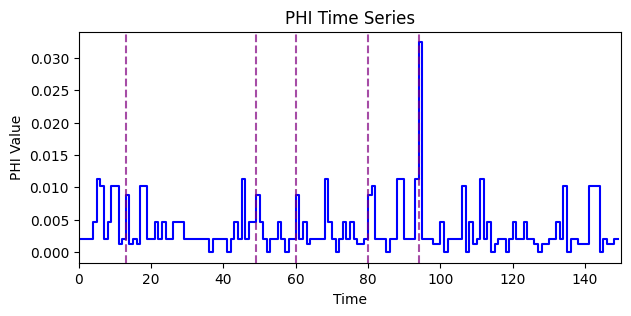

In [ ]:
# Convert each state in combined_activity to a tuple of 0s and 1s
def int_to_tuple(state, num_bits):
    return tuple((state >> i) & 1 for i in range(num_bits - 1, -1, -1))

# Reassigning the phi values to the respective states in the original time series sequence
phi_time_series = np.array([state_to_phi[int_to_tuple(state, num_bits)] for state in combined_activity])

# Setting the limit for the x-axis
max_points = 150

# Plotting the time series of PHI values as a staircase plot
plt.figure(figsize=(7, 3))
plt.step(np.arange(0, max_points), phi_time_series[:max_points], where='post', color='blue')
plt.title('PHI Time Series')
plt.xlabel('Time')
plt.ylabel('PHI Value')
plt.xlim(0, max_points)  # Setting the limit for the x-axis

# Adding vertical lines when both Neuron A and B are active, within the first 1000 points
for t in range(max_points):
    state = int_to_tuple(combined_activity[t], num_bits)
    if state[0] == 1 and state[1] == 1:  # Checking if both Neuron A and B are active
        plt.axvline(x=t, color='purple', linestyle='--', alpha=0.7)

plt.show()

trigger to these events and compute average

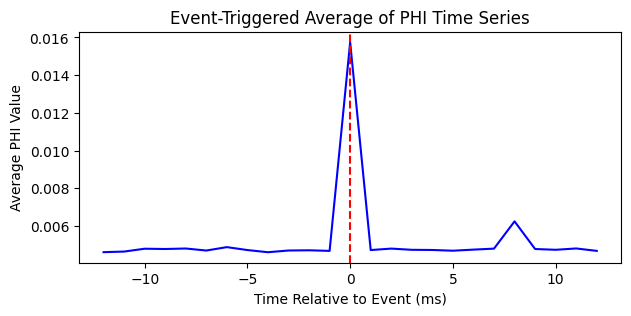

In [ ]:
# Calculating the event-triggered average of phi_time_series

# Parameters for the snippet window
window_pre = 12  # Milliseconds before the event
window_post = 12  # Milliseconds after the event

# List to store all the snippets
snippets = []

# Iterate through the time series to find points where both A and B are active
for t in range(len(combined_activity)):
    state = int_to_tuple(combined_activity[t], num_bits)
    if state[0] == 1 and state[1] == 1:  # Both Neuron A and B are active
        # Calculate start and end indices for the snippet
        start = max(0, t - window_pre)
        end = min(len(phi_time_series), t + window_post + 1)
        snippet = phi_time_series[start:end]
        snippets.append(snippet)

# Averaging the snippets
# Ensuring all snippets are the same length by padding shorter ones with NaN
max_length = max(len(snippet) for snippet in snippets)
padded_snippets = [np.pad(snippet, (0, max_length - len(snippet)), constant_values=np.nan) for snippet in snippets]
average_snippet = np.nanmean(padded_snippets, axis=0)

# Plotting the average snippet
plt.figure(figsize=(7, 3))
plt.plot(np.arange(-window_pre, window_post + 1), average_snippet, color='blue')
plt.title('Event-Triggered Average of PHI Time Series')
plt.xlabel('Time Relative to Event (ms)')
plt.ylabel('Average PHI Value')
plt.axvline(x=0, color='red', linestyle='--')  # Marking the event time
plt.show()

mark 8ms point

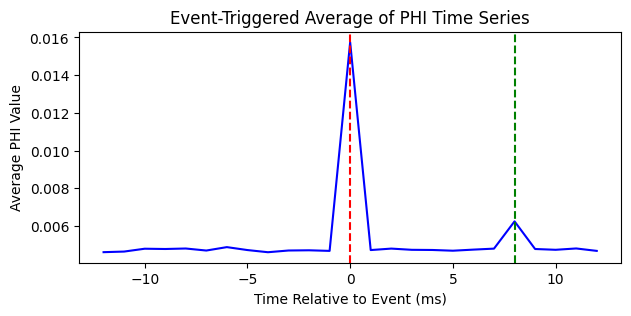

In [ ]:
# Plotting the event-triggered average of PHI time series with an additional marker at 8ms

plt.figure(figsize=(7, 3))
plt.plot(np.arange(-window_pre, window_post + 1), average_snippet, color='blue')
plt.title('Event-Triggered Average of PHI Time Series')
plt.xlabel('Time Relative to Event (ms)')
plt.ylabel('Average PHI Value')
plt.axvline(x=0, color='red', linestyle='--')  # Marking the event time
plt.axvline(x=8, color='green', linestyle='--')  # Additional marker at 8ms
plt.show()

check versus "random control" (A and C co-active)

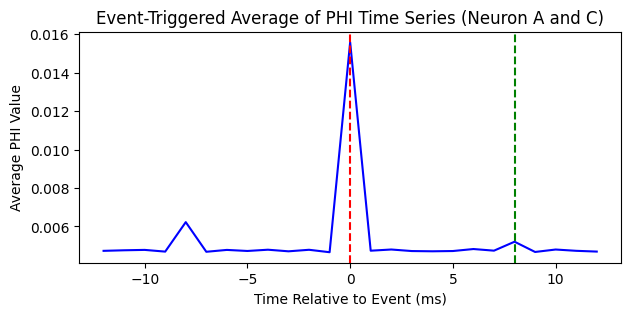

In [39]:
# Calculating the event-triggered average of phi_time_series for when Neuron A and C are simultaneously active

# List to store all the snippets for Neuron A and C being active
snippets_A_C = []

# Iterate through the time series to find points where both A and C are active
for t in range(len(combined_activity)):
    state = int_to_tuple(combined_activity[t], num_bits)
    if state[0] == 1 and state[2] == 1:  # Both Neuron A and C are active
        # Calculate start and end indices for the snippet
        start = max(0, t - window_pre)
        end = min(len(phi_time_series), t + window_post + 1)
        snippet = phi_time_series[start:end]
        snippets_A_C.append(snippet)

# Averaging the snippets for Neuron A and C
padded_snippets_A_C = [np.pad(snippet, (0, max_length - len(snippet)), constant_values=np.nan) for snippet in snippets_A_C]
average_snippet_A_C = np.nanmean(padded_snippets_A_C, axis=0)

# Plotting the average snippet for Neuron A and C
plt.figure(figsize=(7, 3))
plt.plot(np.arange(-window_pre, window_post + 1), average_snippet_A_C, color='blue')
plt.title('Event-Triggered Average of PHI Time Series (Neuron A and C)')
plt.xlabel('Time Relative to Event (ms)')
plt.ylabel('Average PHI Value')
plt.axvline(x=0, color='red', linestyle='--')  # Marking the event time
plt.axvline(x=8, color='green', linestyle='--')  # Additional marker at 8ms
plt.show()

**MECHANISMS**

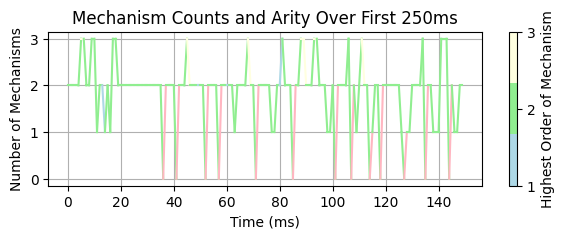

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import itertools

# Extracting the necessary data from phi_results
phi_values = phi_results[0]
phi_states = phi_results[1]
phi_mechanisms = phi_results[4]

# Function to convert state integers to tuples
def int_to_tuple(state, num_bits):
    return tuple((state >> i) & 1 for i in range(num_bits - 1, -1, -1))

# Creating a mapping from states to their index
state_to_index = {tuple(state): index for index, state in enumerate(phi_states)}

# Function to determine the highest order of mechanism
def highest_order(mechanisms):
    return max(len(m) for m in mechanisms) if mechanisms else 0

# Limit to the first xx ms
time_limit = 150

# Mapping the number of mechanisms and their highest orders to the original time series
mechanism_counts = [len(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity[:time_limit]]
highest_orders = [highest_order(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity[:time_limit]]

# Maximum order among all mechanisms
max_order = max(highest_orders)

# Define a custom colormap
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink']  # For orders 1, 2, 3, ...
cmap = mcolors.ListedColormap(colors[:max_order])

# Normalize highest order for color mapping
norm = plt.Normalize(1, max_order)

# Define time_span as the range of time points in the original time series
time_span = np.arange(time_limit)

# Plotting mechanisms and their orders for the first 250ms
fig, ax1 = plt.subplots(figsize=(7, 2))

for i in range(time_limit - 1):
    color_index = highest_orders[i] - 1
    ax1.plot(time_span[i:i+2], mechanism_counts[i:i+2], color=colors[color_index], linestyle='-')

# Create the discrete colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, ticks=range(1, max_order + 1))
cbar.set_label('Highest Order of Mechanism')

# Set labels and titles
ax1.set_title("Mechanism Counts and Arity Over First 250ms")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Number of Mechanisms")
ax1.grid(True)

plt.show()

event-trigger

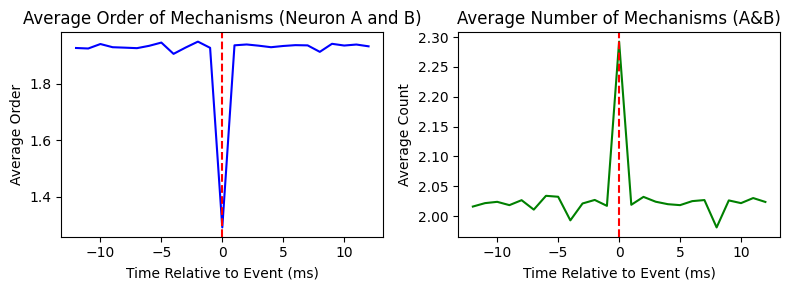

In [51]:
# when Neuron A and B are simultaneously active
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Extracting the necessary data from phi_results
phi_values = phi_results[0]
phi_states = phi_results[1]
phi_mechanisms = phi_results[4]

# Function to convert state integers to tuples
def int_to_tuple(state, num_bits):
    return tuple((state >> i) & 1 for i in range(num_bits - 1, -1, -1))

# Creating a mapping from states to their index in phi_mechanisms
state_to_index = {tuple(state): index for index, state in enumerate(phi_states)}

# Function to determine the highest order of mechanism
def highest_order(mechanisms):
    return max(len(m) for m in mechanisms) if mechanisms else 0

# Mapping the number of mechanisms and their highest orders to the original time series
mechanism_counts = [len(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity]
highest_orders = [highest_order(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity]

# Parameters for the snippet window
window_pre = 12  # Milliseconds before the event
window_post = 12  # Milliseconds after the event

# Lists to store all the snippets for order and number of mechanisms
snippets_order = []
snippets_count = []

# Iterate through the time series to find points where both A and B are active
for t in range(len(combined_activity)):
    state = int_to_tuple(combined_activity[t], num_bits)
    if state[0] == 1 and state[1] == 1:  # Both Neuron A and B are active
        # Calculate start and end indices for the snippet
        start = max(0, t - window_pre)
        end = min(len(combined_activity), t + window_post + 1)
        snippet_order = highest_orders[start:end]
        snippet_count = mechanism_counts[start:end]
        snippets_order.append(snippet_order)
        snippets_count.append(snippet_count)

# Convert snippets to float type to allow padding with NaN
max_length_order = max(len(snippet) for snippet in snippets_order)
max_length_count = max(len(snippet) for snippet in snippets_count)
padded_snippets_order = [np.pad(np.asarray(snippet, dtype=float), (0, max_length_order - len(snippet)), constant_values=np.nan) for snippet in snippets_order]
padded_snippets_count = [np.pad(np.asarray(snippet, dtype=float), (0, max_length_count - len(snippet)), constant_values=np.nan) for snippet in snippets_count]

# Calculate the averages
average_snippet_order = np.nanmean(padded_snippets_order, axis=0)
average_snippet_count = np.nanmean(padded_snippets_count, axis=0)

# Plotting the event-triggered averages side-by-side
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot for average order of mechanisms
axs[0].plot(np.arange(-window_pre, window_post + 1), average_snippet_order, color='blue')
axs[0].set_title('Average Order of Mechanisms (Neuron A and B)')
axs[0].set_xlabel('Time Relative to Event (ms)')
axs[0].set_ylabel('Average Order')
axs[0].axvline(x=0, color='red', linestyle='--')

# Plot for average number of mechanisms
axs[1].plot(np.arange(-window_pre, window_post + 1), average_snippet_count, color='green')
axs[1].set_title('Average Number of Mechanisms (A&B)')
axs[1].set_xlabel('Time Relative to Event (ms)')
axs[1].set_ylabel('Average Count')
axs[1].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

control

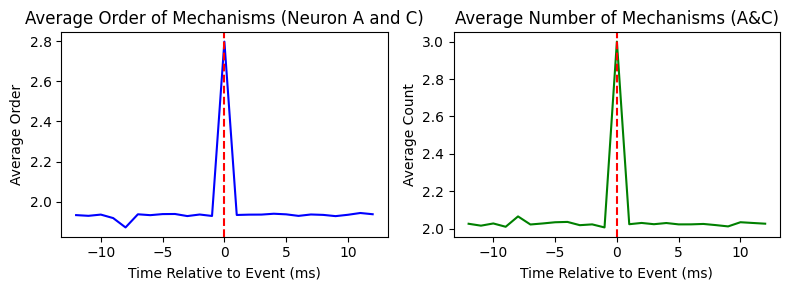

In [50]:
# when Neuron A and C are simultaneously active
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Extracting the necessary data from phi_results
phi_values = phi_results[0]
phi_states = phi_results[1]
phi_mechanisms = phi_results[4]

# Function to convert state integers to tuples
def int_to_tuple(state, num_bits):
    return tuple((state >> i) & 1 for i in range(num_bits - 1, -1, -1))

# Creating a mapping from states to their index in phi_mechanisms
state_to_index = {tuple(state): index for index, state in enumerate(phi_states)}

# Function to determine the highest order of mechanism
def highest_order(mechanisms):
    return max(len(m) for m in mechanisms) if mechanisms else 0

# Mapping the number of mechanisms and their highest orders to the original time series
mechanism_counts = [len(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity]
highest_orders = [highest_order(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity]

# Parameters for the snippet window
window_pre = 12  # Milliseconds before the event
window_post = 12  # Milliseconds after the event

# Lists to store all the snippets for order and number of mechanisms
snippets_order = []
snippets_count = []

# Iterate through the time series to find points where both A and B are active
for t in range(len(combined_activity)):
    state = int_to_tuple(combined_activity[t], num_bits)
    if state[0] == 1 and state[2] == 1:  # Both Neuron A and B are active
        # Calculate start and end indices for the snippet
        start = max(0, t - window_pre)
        end = min(len(combined_activity), t + window_post + 1)
        snippet_order = highest_orders[start:end]
        snippet_count = mechanism_counts[start:end]
        snippets_order.append(snippet_order)
        snippets_count.append(snippet_count)

# Convert snippets to float type to allow padding with NaN
max_length_order = max(len(snippet) for snippet in snippets_order)
max_length_count = max(len(snippet) for snippet in snippets_count)
padded_snippets_order = [np.pad(np.asarray(snippet, dtype=float), (0, max_length_order - len(snippet)), constant_values=np.nan) for snippet in snippets_order]
padded_snippets_count = [np.pad(np.asarray(snippet, dtype=float), (0, max_length_count - len(snippet)), constant_values=np.nan) for snippet in snippets_count]

# Calculate the averages
average_snippet_order = np.nanmean(padded_snippets_order, axis=0)
average_snippet_count = np.nanmean(padded_snippets_count, axis=0)

# Plotting the event-triggered averages side-by-side
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot for average order of mechanisms
axs[0].plot(np.arange(-window_pre, window_post + 1), average_snippet_order, color='blue')
axs[0].set_title('Average Order of Mechanisms (Neuron A and C)')
axs[0].set_xlabel('Time Relative to Event (ms)')
axs[0].set_ylabel('Average Order')
axs[0].axvline(x=0, color='red', linestyle='--')

# Plot for average number of mechanisms
axs[1].plot(np.arange(-window_pre, window_post + 1), average_snippet_count, color='green')
axs[1].set_title('Average Number of Mechanisms (A&C)')
axs[1].set_xlabel('Time Relative to Event (ms)')
axs[1].set_ylabel('Average Count')
axs[1].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

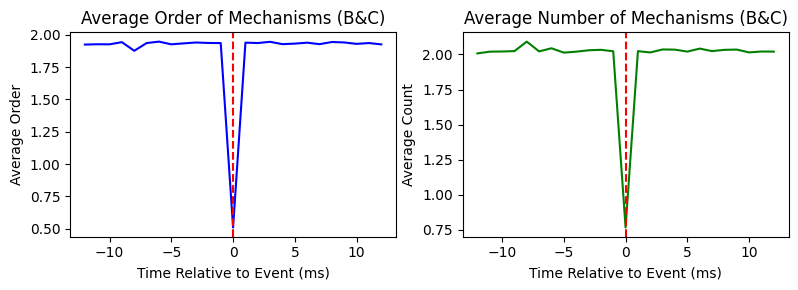

In [52]:
# when Neuron A and C are simultaneously active
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Extracting the necessary data from phi_results
phi_values = phi_results[0]
phi_states = phi_results[1]
phi_mechanisms = phi_results[4]

# Function to convert state integers to tuples
def int_to_tuple(state, num_bits):
    return tuple((state >> i) & 1 for i in range(num_bits - 1, -1, -1))

# Creating a mapping from states to their index in phi_mechanisms
state_to_index = {tuple(state): index for index, state in enumerate(phi_states)}

# Function to determine the highest order of mechanism
def highest_order(mechanisms):
    return max(len(m) for m in mechanisms) if mechanisms else 0

# Mapping the number of mechanisms and their highest orders to the original time series
mechanism_counts = [len(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity]
highest_orders = [highest_order(phi_mechanisms[state_to_index[int_to_tuple(state, num_bits)]]) for state in combined_activity]

# Parameters for the snippet window
window_pre = 12  # Milliseconds before the event
window_post = 12  # Milliseconds after the event

# Lists to store all the snippets for order and number of mechanisms
snippets_order = []
snippets_count = []

# Iterate through the time series to find points where both A and B are active
for t in range(len(combined_activity)):
    state = int_to_tuple(combined_activity[t], num_bits)
    if state[1] == 1 and state[2] == 1:  # Both Neuron A and B are active
        # Calculate start and end indices for the snippet
        start = max(0, t - window_pre)
        end = min(len(combined_activity), t + window_post + 1)
        snippet_order = highest_orders[start:end]
        snippet_count = mechanism_counts[start:end]
        snippets_order.append(snippet_order)
        snippets_count.append(snippet_count)

# Convert snippets to float type to allow padding with NaN
max_length_order = max(len(snippet) for snippet in snippets_order)
max_length_count = max(len(snippet) for snippet in snippets_count)
padded_snippets_order = [np.pad(np.asarray(snippet, dtype=float), (0, max_length_order - len(snippet)), constant_values=np.nan) for snippet in snippets_order]
padded_snippets_count = [np.pad(np.asarray(snippet, dtype=float), (0, max_length_count - len(snippet)), constant_values=np.nan) for snippet in snippets_count]

# Calculate the averages
average_snippet_order = np.nanmean(padded_snippets_order, axis=0)
average_snippet_count = np.nanmean(padded_snippets_count, axis=0)

# Plotting the event-triggered averages side-by-side
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot for average order of mechanisms
axs[0].plot(np.arange(-window_pre, window_post + 1), average_snippet_order, color='blue')
axs[0].set_title('Average Order of Mechanisms (B&C)')
axs[0].set_xlabel('Time Relative to Event (ms)')
axs[0].set_ylabel('Average Order')
axs[0].axvline(x=0, color='red', linestyle='--')

# Plot for average number of mechanisms
axs[1].plot(np.arange(-window_pre, window_post + 1), average_snippet_count, color='green')
axs[1].set_title('Average Number of Mechanisms (B&C)')
axs[1].set_xlabel('Time Relative to Event (ms)')
axs[1].set_ylabel('Average Count')
axs[1].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()